# Modelo de machine learning para el apoyo diagnóstico temprano: una solución para la eficiencia hospitalaria y sostenibilidad del sistema de salud

Este notebook tiene como objetivo desarrollar un modelo de clasificación para predecir diagnósticos médicos a partir de síntomas reportados por pacientes



In [ ]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from pycaret.classification import setup
from pycaret.classification import *
from pycaret.classification import load_model
from pycaret.classification import models

## 1. Carga del Dataset

Primero, se importa la biblioteca pandas y se carga el archivo CSV con el conjunto de datos de enfermedades y síntomas. Este dataset contiene una columna llamada diseases que representa el diagnóstico, y varias columnas que indican la presencia o ausencia de síntomas codificadas como One Hot Encoders

In [3]:
# Cargar el archivo
df = pd.read_csv(r"Final_Augmented_dataset_Diseases_and_Symptoms.csv")

In [4]:
df

,diseases,anxiety and nervousness,depression,shortness of breath,depressive or psychotic symptoms,sharp chest pain,dizziness,insomnia,abnormal involuntary movements,chest tightness,...,stuttering or stammering,problems with orgasm,nose deformity,lump over jaw,sore in nose,hip weakness,back swelling,ankle stiffness or tightness,ankle weakness,neck weakness
0,panic disorder,1,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,panic disorder,0,0,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,panic disorder,1,1,1,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,panic disorder,1,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,panic disorder,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246940,open wound of the nose,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246941,open wound of the nose,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246942,open wound of the nose,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246943,open wound of the nose,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Exploración Inicial: Distribución de Diagnósticos

Se realiza un conteo de la cantidad de registros disponibles para cada diagnóstico. Esto permite identificar si existen clases con muy pocos ejemplos, lo cual podría perjudicar el entrenamiento del modelo.

Además, se imprime:

El número total de diagnósticos únicos.

La cantidad de diagnósticos con solo un registro (clases demasiado escasas).

In [22]:
print(df.shape)
print("-"*150)
print("tipos de datos:")
print(df.dtypes)
print("-"*150)
print("distribución de enfermedades:")
print(df['diseases'].value_counts())
print("-"*150)
print("valores nulos:")
print(df.isnull().sum())


(246945, 378)
------------------------------------------------------------------------------------------------------------------------------------------------------
tipos de datos:
diseases                            object
anxiety and nervousness              int64
depression                           int64
shortness of breath                  int64
depressive or psychotic symptoms     int64
                                     ...  
hip weakness                         int64
back swelling                        int64
ankle stiffness or tightness         int64
ankle weakness                       int64
neck weakness                        int64
Length: 378, dtype: object
------------------------------------------------------------------------------------------------------------------------------------------------------
distribución de enfermedades:
cystitis                          1219
vulvodynia                        1218
nose disorder                     1218
complex regional pain

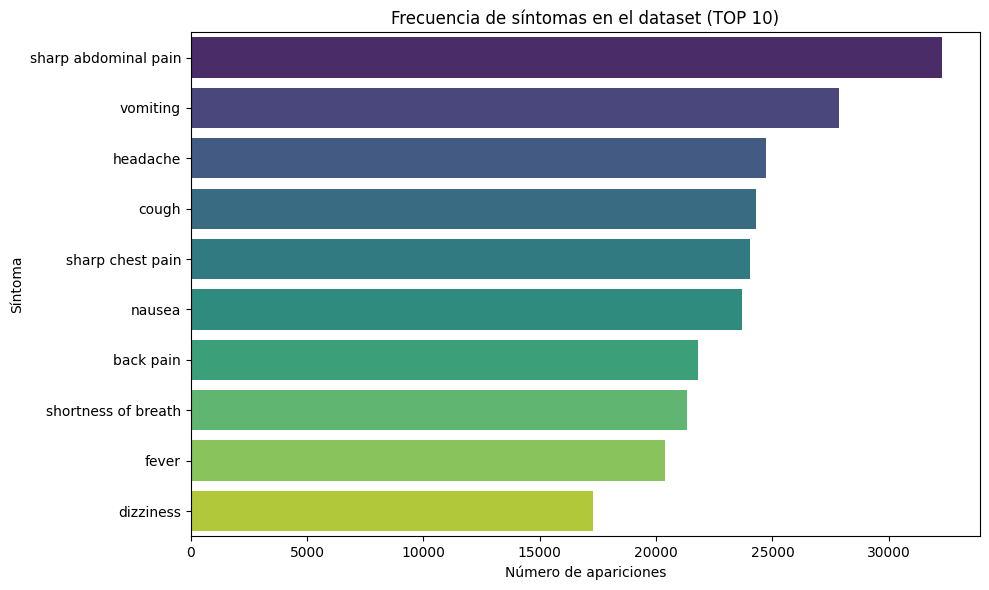

In [ ]:

symptom_counts = df.drop(columns='diseases').sum().sort_values(ascending=False)


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=symptom_counts.values[:10], y=symptom_counts.index[:10], palette='viridis')
plt.title('Frecuencia de síntomas en el dataset (TOP 10)')
plt.xlabel('Número de apariciones')
plt.ylabel('Síntoma')
plt.tight_layout()
plt.show()


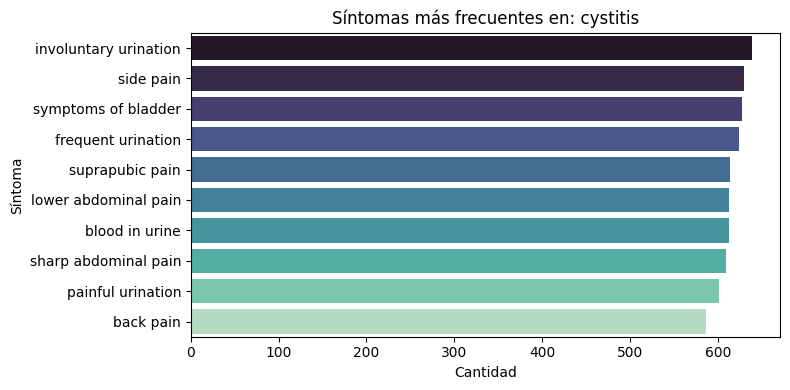

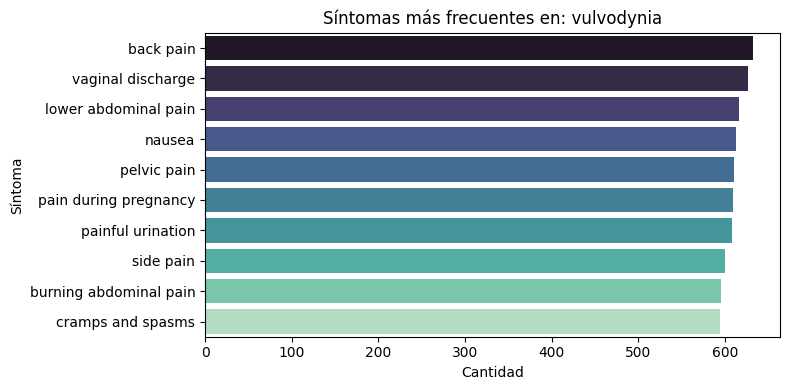

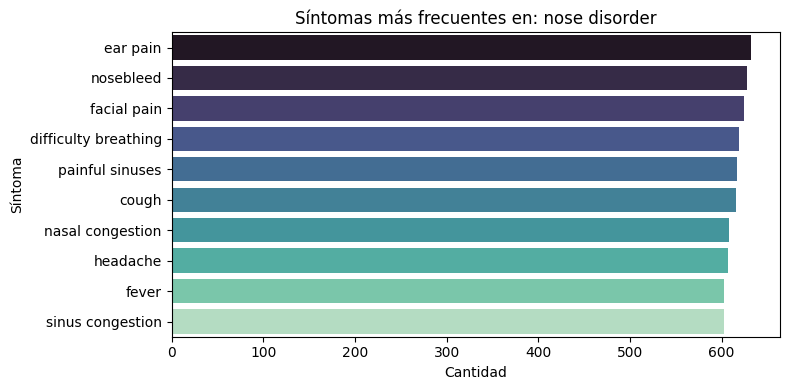

In [28]:
top_diseases = df['diseases'].value_counts().head(3).index

for disease in top_diseases:
    subset = df[df['diseases'] == disease]
    top_symptoms = subset.drop(columns='diseases').sum().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_symptoms.values, y=top_symptoms.index, palette='mako')
    plt.title(f'Síntomas más frecuentes en: {disease}')
    plt.xlabel('Cantidad')
    plt.ylabel('Síntoma')
    plt.tight_layout()
    plt.show()


In [5]:
# Contar cuántos registros hay por diagnóstico
conteo_diagnosticos = df['diseases'].value_counts()

# Ver los diagnósticos que solo tienen un registro
diagnosticos_unicos = conteo_diagnosticos[conteo_diagnosticos == 1]

# Mostrar resumen
print(f"Número total de diagnósticos únicos: {conteo_diagnosticos.shape[0]}")
print(f"Número de diagnósticos con solo un registro: {diagnosticos_unicos.shape[0]}")

Número total de diagnósticos únicos: 773
Número de diagnósticos con solo un registro: 19


## 3. Filtrado de Diagnósticos con Pocos Registros

Para asegurar una mejor calidad del modelo, se excluyen los diagnósticos que tienen menos de un umbral mínimo de registros (definido en 100 registros). Esto permite centrarse en las clases más representativas y con una cantidad de informacion considerable al momento del entrenamiento.

Se imprime:

El número de diagnósticos que cumplen con el umbral.

El tamaño del nuevo dataset resultante.



In [6]:
umbral = 100  # o el valor que decidas
diagnosticos_validos = df['diseases'].value_counts()
diagnosticos_filtrados = diagnosticos_validos[diagnosticos_validos >= umbral].index

df_filtrado = df[df['diseases'].isin(diagnosticos_filtrados)]
print(f"Número de diagnósticos incluidos: {len(diagnosticos_filtrados)}")
print(f"Nuevo tamaño del dataset: {df_filtrado.shape}")


Número de diagnósticos incluidos: 443
Nuevo tamaño del dataset: (236619, 378)


## 4. Visualización de Diagnósticos Filtrados

Se crea una gráfica de barras que muestra la cantidad de registros por diagnóstico, una vez aplicado el filtrado. Esta visualización ayuda a entender cómo está distribuido el nuevo dataset y qué diagnósticos son los más frecuentes y menos frecuentes

cystitis         1219
nose disorder    1218
vulvodynia       1218
Name: diseases, dtype: int64


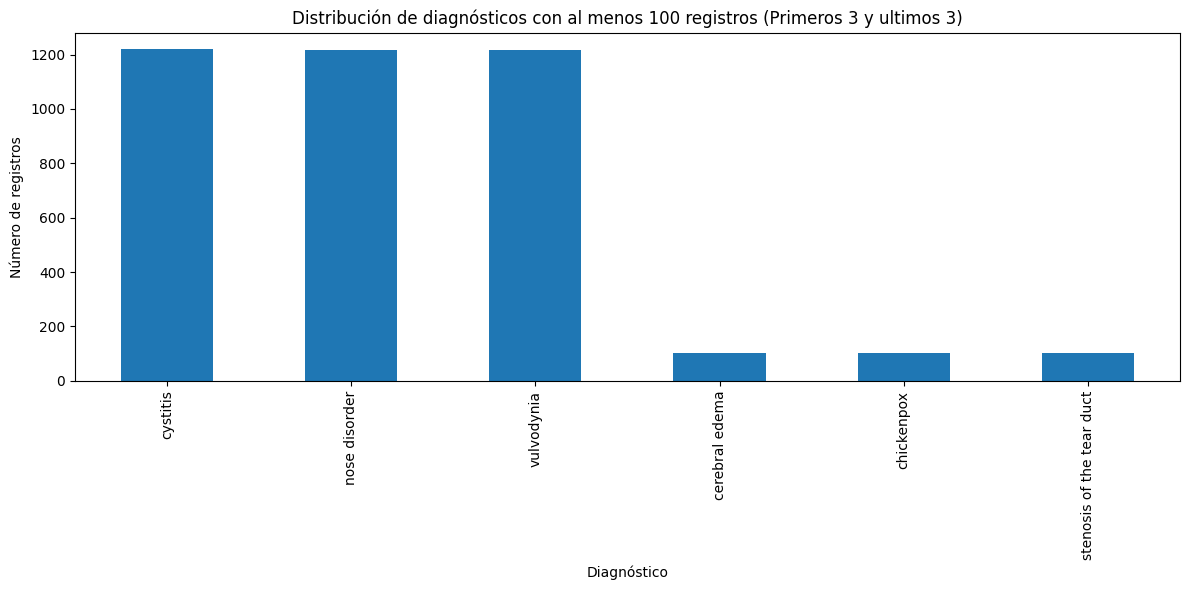

In [ ]:
import matplotlib.pyplot as plt

# Ver cuántos diagnósticos quedan y cuántos registros tiene cada uno
conteo_filtrado = df_filtrado['diseases'].value_counts()

# Unirlos (si es una lista)
resultado = pd.concat([conteo_filtrado[:3], conteo_filtrado[-3:]])


# Mostrar un resumen de los diagnósticos más comunes
print(primeros_3)  # Top 10 diagnósticos más frecuentes

# Visualizar la distribución
plt.figure(figsize=(12, 6))
resultado.plot(kind='bar')
plt.title('Distribución de diagnósticos con al menos 100 registros (Primeros 3 y ultimos 3)')
plt.xlabel('Diagnóstico')
plt.ylabel('Número de registros')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## 5. División del Dataset
Se divide el conjunto de datos filtrado en un conjunto de entrenamiento (df_train) y otro de prueba (df_test), utilizando una división estratificada para mantener la proporción de cada clase. Esta separación es fundamental para entrenar el modelo y luego evaluarlo con datos no vistos.

In [ ]:


df_train, df_test = train_test_split(df_filtrado, test_size=0.2, random_state=42, stratify=df_filtrado['diseases'])
#df_train.to_csv("df_train.csv")
#df_test.to_csv("df_test.csv")


## 6. Configuración del Entorno Automático de Modelado con PyCaret
En esta sección se utiliza PyCaret, una biblioteca de código abierto para machine learning automatizado (AutoML). PyCaret permite entrenar, comparar y optimizar modelos de clasificación con una mínima cantidad de código, facilitando el trabajo especialmente en proyectos exploratorios o prototipos rápidos.

### ¿Cómo funciona PyCaret?
Al ejecutar la función setup(), PyCaret realiza automáticamente:

Análisis de tipo de variables (numéricas, categóricas, booleanas, etc.).

Codificación de variables categóricas (One-Hot Encoding o Label Encoding según corresponda).

Imputación de valores faltantes si es necesario.

Normalización o estandarización de variables numéricas.

Separación entre variables predictoras (features) y la variable objetivo (target).

Partición del conjunto de datos en entrenamiento y validación.

Aplicación de validación cruzada (cross-validation) de forma predeterminada, típicamente con 10 particiones (K-Fold CV) para garantizar estimaciones más robustas del desempeño del modelo.

### ¿Por qué es confiable?
PyCaret implementa buenas prácticas de machine learning por defecto:

Evalúa todos los modelos bajo un esquema de validación cruzada, reduciendo el riesgo de sobreajuste.

Calcula múltiples métricas de evaluación (Accuracy, Precision, Recall, F1-Score, AUC).

Establece una session_id para asegurar reproducibilidad.

Permite integrar técnicas avanzadas como ajuste de hiperparámetros, selección automática de características, interpretabilidad del modelo (SHAP), entre otros.

Con el entorno configurado en PyCaret, se utiliza la función compare_models() para evaluar varios modelos de clasificación. En este caso, se comparan algoritmos específicos como:

Regresión logística (lr)

Vecinos más cercanos (knn)

Naive Bayes (nb)

Árboles de decisión (dt)

Análisis discriminante cuadrático (qda)

Análisis discriminante lineal (lda)

Regresión Ridge (ridge)

Extra Trees (et)

PyCaret evalúa automáticamente estos modelos utilizando métricas como precisión, F1-score, AUC, etc., y selecciona los mejores en función del desempeño.




In [ ]:


# Paso 1: Configurar PyCaret (usa df_train y la columna 'diseases' como objetivo)
clf_setup = setup(
    data=df_train,
    target='diseases',
    session_id=42,
    test_data=df_test  # Esto permite evaluar en conjunto de prueba
)

top_modelos= compare_models(include=["lr","knn","nb","dt","qda","lda","ridge","et"],n_select=5)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8675,0.0000,0.8675,0.8765,0.8678,0.8671,0.8672,78.8170
nb,Naive Bayes,0.8669,0.9997,0.8669,0.8894,0.8689,0.8665,0.8666,44.1150
qda,Quadratic Discriminant Analysis,0.8274,0.0000,0.8274,0.8521,0.8241,0.8269,0.8270,62.0260
knn,K Neighbors Classifier,0.8250,0.9664,0.8250,0.8324,0.8253,0.8245,0.8245,53.6470
dt,Decision Tree Classifier,0.8150,0.9194,0.8150,0.8191,0.8146,0.8145,0.8145,8.4030
lda,Linear Discriminant Analysis,0.7195,0.0000,0.7195,0.8170,0.7344,0.7187,0.7189,9.0900
ridge,Ridge Classifier,0.6643,0.0000,0.6643,0.6768,0.6274,0.6631,0.6634,3.5630


c:\Users\Juan Pablo Bertel M\Desktop\Proyecto_integrador_2\venv\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py:339: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(highlight_cols, subset=["TT (Sec)"])


AttributeError: 'LogisticRegression' object has no attribute '_class_'

## 8. Guardado de Modelos Iniciales

Después de seleccionar los mejores modelos, cada uno se guarda en disco utilizando save_model(). Esto permite reutilizar los modelos posteriormente sin necesidad de volver a entrenarlos desde cero.

In [20]:
# Guardar los modelos
for modelo in top_modelos:
    nombre_modelo = modelo.__class__.__name__
    save_model(modelo, f"modelo_{nombre_modelo}")

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


## 9. Optimización de Modelos (Tuning)
Se aplica un proceso de ajuste de hiperparámetros (tune_model()) sobre cada modelo previamente seleccionado, optimizando la métrica F1. Esta etapa busca mejorar el desempeño de cada clasificador mediante una búsqueda simple en el espacio de hiperparámetros.

Cada modelo optimizado también se guarda con un nombre distinto.

In [ ]:

clf_setup = setup(
    data=df_train,
    target='diseases',
    session_id=42,
    test_data=df_test,
    n_jobs=-1,
    fold=5
)


In [ ]:

modelo = load_model("modelo_DecisionTreeClassifier")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_De{nombre_modelo}")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8658,0.0000,0.8658,0.8820,0.8672,0.8654,0.8655
1,0.8674,0.0000,0.8674,0.8835,0.8688,0.8670,0.8671
2,0.8674,0.0000,0.8674,0.8835,0.8688,0.8670,0.8671
3,0.8726,0.0000,0.8726,0.8870,0.8740,0.8722,0.8722
4,0.8694,0.0000,0.8694,0.8848,0.8706,0.8690,0.8690
Mean,0.8685,0.0000,0.8685,0.8841,0.8699,0.8681,0.8682
Std,0.0023,0.0000,0.0023,0.0017,0.0023,0.0023,0.0023


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                  TransformerWrapper(exclude=None, include=None,
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('trained_mo

In [19]:
modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_De{nombre_modelo}")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.0662,0.5834,0.0662,0.1188,0.0774,0.0614,0.1495
1,0.0680,0.5768,0.0680,0.1245,0.0802,0.0632,0.1606
2,0.0655,0.5773,0.0655,0.1124,0.0754,0.0607,0.1538
3,0.0649,0.5746,0.0649,0.1165,0.0762,0.0601,0.1550
4,0.0655,0.5695,0.0655,0.1219,0.0786,0.0607,0.1621
Mean,0.0660,0.5763,0.0660,0.1188,0.0776,0.0612,0.1562
Std,0.0011,0.0045,0.0011,0.0042,0.0017,0.0011,0.0046


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                     transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+'))),
                 ('trained_model',
                  DecisionTreeClassifier(ccp_alpha=0.0, cla

In [12]:
modelo = load_model("modelo_KNeighborsClassifier")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_KNN{nombre_modelo}")


Transformation Pipeline and Model Successfully Loaded


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8583,0.9982,0.8583,0.8660,0.8587,0.8578,0.8579
1,0.8621,0.9984,0.8621,0.8688,0.8627,0.8616,0.8617
2,0.8604,0.9982,0.8604,0.8680,0.8609,0.8600,0.8600
3,0.8630,0.9984,0.8630,0.8700,0.8635,0.8626,0.8626
4,0.8596,0.9984,0.8596,0.8665,0.8600,0.8591,0.8591
Mean,0.8607,0.9983,0.8607,0.8678,0.8612,0.8602,0.8603
Std,0.0017,0.0001,0.0017,0.0015,0.0017,0.0017,0.0017


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                        

In [13]:
modelo = load_model("modelo_GaussianNB")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_GaussianNB{nombre_modelo}")


Transformation Pipeline and Model Successfully Loaded


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8641,0.9997,0.8641,0.8864,0.8658,0.8637,0.8637
1,0.8657,0.9997,0.8657,0.8875,0.8678,0.8653,0.8653
2,0.8669,0.9997,0.8669,0.8876,0.8686,0.8665,0.8666
3,0.8702,0.9997,0.8702,0.8912,0.8724,0.8698,0.8699
4,0.8685,0.9997,0.8685,0.8896,0.8705,0.8681,0.8681
Mean,0.8671,0.9997,0.8671,0.8884,0.8690,0.8667,0.8667
Std,0.0021,0.0000,0.0021,0.0017,0.0023,0.0021,0.0021


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                       

In [15]:
modelo = load_model("modelo_GaussianNB")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=10, n_iter=20)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_GaussianNB{nombre_modelo}")

Transformation Pipeline and Model Successfully Loaded


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8703,0.9997,0.8703,0.8895,0.8711,0.8699,0.8700
1,0.8655,0.9997,0.8655,0.8863,0.8665,0.8651,0.8652
2,0.8687,0.9997,0.8687,0.8889,0.8702,0.8683,0.8684
3,0.8728,0.9997,0.8728,0.8920,0.8743,0.8725,0.8725
4,0.8684,0.9997,0.8684,0.8872,0.8693,0.8680,0.8680
5,0.8738,0.9997,0.8738,0.8920,0.8749,0.8735,0.8735
6,0.8729,0.9997,0.8729,0.8922,0.8741,0.8726,0.8726
7,0.8755,0.9997,0.8755,0.8937,0.8768,0.8752,0.8752
8,0.8752,0.9997,0.8752,0.8936,0.8766,0.8748,0.8749


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                       

In [14]:
modelo = load_model("modelo_QuadraticDiscriminantAnalysis")

modelo_tuneado = tune_model(modelo, optimize='F1', fold=5, n_iter=10)

# Extraer nombre del modelo base (ya que el tuneado es una instancia del mismo tipo)
nombre_modelo = modelo.__class__.__name__

# Guardar el modelo tuneado
save_model(modelo_tuneado, f"modelo_tuneado_modelo_QuadraticDiscriminantAnalysis{nombre_modelo}")


Transformation Pipeline and Model Successfully Loaded


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5818,0.0000,0.5818,0.4365,0.4839,0.5803,0.5808
1,0.5823,0.0000,0.5823,0.4340,0.4838,0.5808,0.5813
2,0.5797,0.0000,0.5797,0.4336,0.4821,0.5781,0.5786
3,0.5839,0.0000,0.5839,0.4369,0.4857,0.5824,0.5829
4,0.5830,0.0000,0.5830,0.4356,0.4850,0.5815,0.5820
Mean,0.5821,0.0000,0.5821,0.4353,0.4841,0.5806,0.5811
Std,0.0014,0.0000,0.0014,0.0013,0.0012,0.0014,0.0014


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp chest pain', 'dizziness',
                                              'insomnia',
                                              'abnormal in...
                                                               copy=True,
                                                               fill_value=None,
                                           

## 10. Evaluación del Modelo y Matriz de Confusión
Para evaluar el rendimiento de los modelos seleccionados y afinados, se realiza una predicción sobre el conjunto de prueba (df_test). A partir de esto, se comparan las etiquetas verdaderas (y_true) con las etiquetas predichas (y_pred).

Se construye una matriz de confusión usando únicamente las 10 clases (diagnósticos) más frecuentes, lo que permite visualizar de forma clara qué tan bien clasifica el modelo en las clases más representativas.

In [ ]:
#evaluaciones
modelo = load_model("modelo_QuadraticDiscriminantAnalysis")

Transformation Pipeline and Model Successfully Loaded


In [18]:
print(modelo)

Pipeline(memory=FastMemory(location=C:\Users\JUANPA~1\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['anxiety and nervousness',
                                             'depression',
                                             'shortness of breath',
                                             'depressive or psychotic symptoms',
                                             'sharp ch...
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              mi

In [ ]:
#modelo = load_model("modelo_QuadraticDiscriminantAnalysis")
evaluate_model(modelo)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<Figure size 800x550 with 0 Axes>

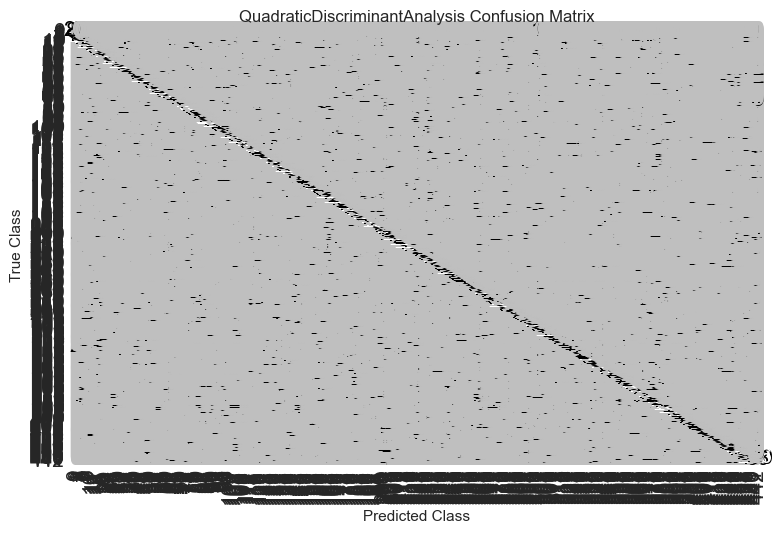

In [22]:
plot_model(modelo, plot='confusion_matrix')

In [26]:
from pycaret.classification import predict_model

# Obtener predicciones sobre el test set
df_pred = predict_model(modelo, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.8343,0.9735,0.8343,0.8504,0.8294,0.8338,0.8339


In [27]:
df_pred["prediction_score"].value_counts()

prediction_score
1.0000    45471
0.9999      177
0.9998       73
0.9997       65
0.9994       41
          ...  
0.7188        1
0.9839        1
0.7081        1
0.9463        1
0.8279        1
Name: count, Length: 718, dtype: int64

## 11. Evaluación de Todos los Modelos Afinados
El notebook carga cada modelo previamente afinado y guardado, aplicando las siguientes acciones:

Carga del modelo.

Predicción sobre el conjunto de prueba.

Selección de las 10 clases más frecuentes.

Construcción y visualización de la matriz de confusión.

Guardado automático de la gráfica en formato PNG.

Esto permite comparar visualmente el desempeño de cada modelo de forma automatizada.

In [31]:
# Variables reales y predichas
y_true = df_test['diseases']
y_pred = df_pred['prediction_label']

In [32]:
from collections import Counter
import numpy as np

# Obtener las 10 clases más frecuentes
top_classes = [label for label, _ in Counter(y_true).most_common(10)]

# Filtrar para mostrar solo esas clases
mask = y_true.isin(top_classes)
y_true_top = y_true[mask]
y_pred_top = y_pred[mask]


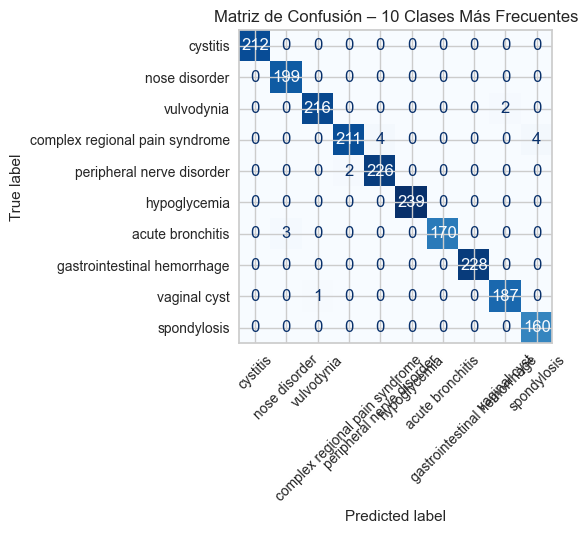

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_top, y_pred_top, labels=top_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_classes)
disp.plot(xticks_rotation=45, cmap='Blues', colorbar=False)
plt.title("Matriz de Confusión – 10 Clases Más Frecuentes")
plt.tight_layout()
plt.show()


📊 Procesando modelo_tuneado_modelo_QuadraticDiscriminantAnalysisPipeline...
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.8343,0.9735,0.8343,0.8504,0.8294,0.8338,0.8339


⚠️ Error con modelo_tuneado_modelo_QuadraticDiscriminantAnalysisPipeline: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_modelo_QuadraticDiscriminantAnalysisPipeline_confusion.png'
📊 Procesando modelo_tuneado_logistic...
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8690,0.9997,0.8690,0.8844,0.8704,0.8686,0.8687


⚠️ Error con modelo_tuneado_logistic: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_logistic_confusion.png'
📊 Procesando modelo_tuneado_KNNPipeline...
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8636,0.9984,0.8636,0.8707,0.8643,0.8632,0.8632


⚠️ Error con modelo_tuneado_KNNPipeline: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_KNNPipeline_confusion.png'
📊 Procesando modelo_tuneado_GaussianNBPipeline...
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8726,0.9997,0.8726,0.8899,0.8736,0.8722,0.8722


⚠️ Error con modelo_tuneado_GaussianNBPipeline: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_GaussianNBPipeline_confusion.png'
📊 Procesando modelo_tuneado_DePipeline...
Transformation Pipeline and Model Successfully Loaded


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.8174,0.9224,0.8174,0.8204,0.8173,0.8169,0.8169


⚠️ Error con modelo_tuneado_DePipeline: [Errno 2] No such file or directory: 'matrices_confusion/modelo_tuneado_DePipeline_confusion.png'


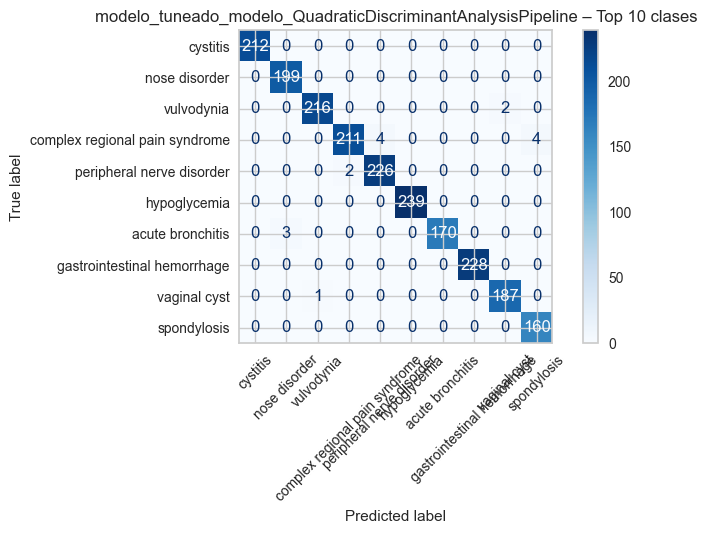

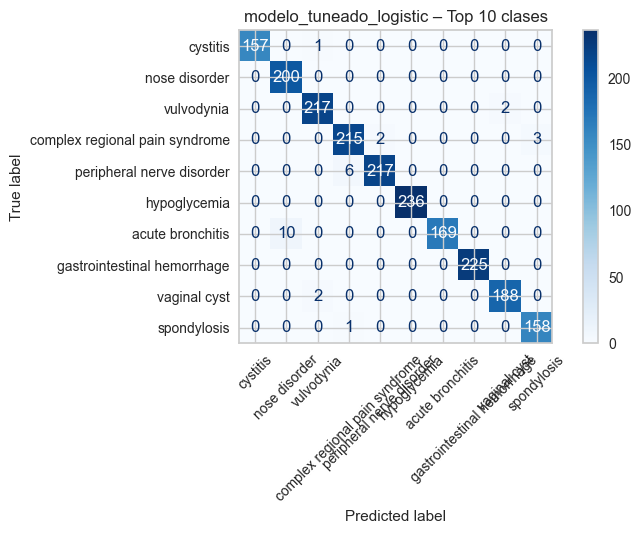

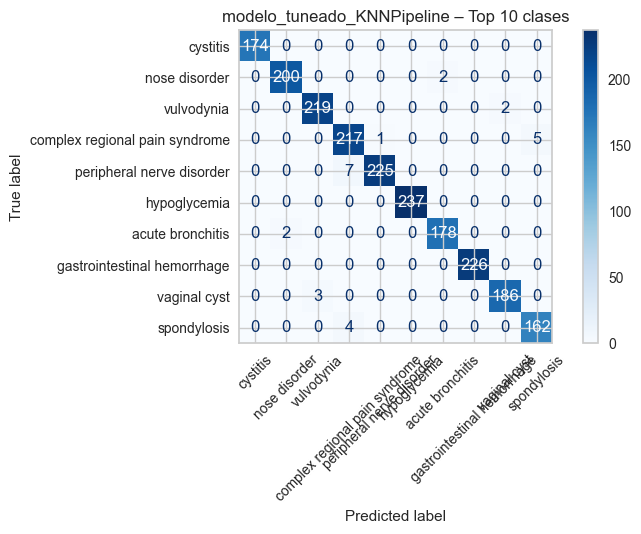

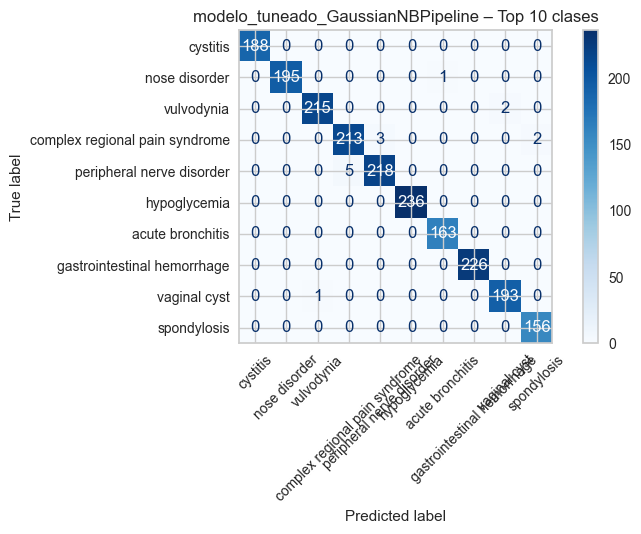

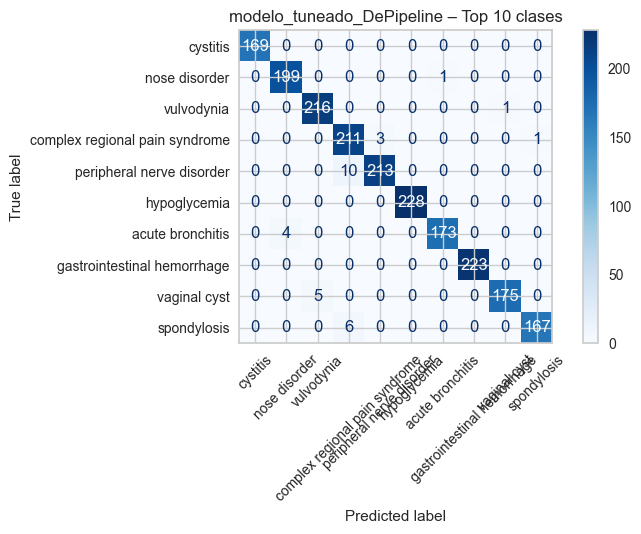

In [35]:
# Cargar todos los modelos .pkl en esa carpeta
modelos = ["modelo_tuneado_modelo_QuadraticDiscriminantAnalysisPipeline","modelo_tuneado_logistic","modelo_tuneado_KNNPipeline","modelo_tuneado_GaussianNBPipeline","modelo_tuneado_DePipeline"]

for archivo in modelos:
    try:
        nombre_modelo = archivo.replace('.pkl', '')
        print(f"📊 Procesando {nombre_modelo}...")

        # 1. Cargar modelo
        modelo = load_model(nombre_modelo)

        # 2. Predecir sobre df_test
        df_pred = predict_model(modelo, data=df_test)

        # 3. Extraer etiquetas reales y predichas
        y_true = df_pred['diseases']
        y_pred = df_pred['prediction_label']

        # 4. Seleccionar 10 clases más frecuentes
        top_classes = [label for label, _ in Counter(y_true).most_common(10)]
        mask = y_true.isin(top_classes)
        y_true_top = y_true[mask]
        y_pred_top = y_pred[mask]

        # 5. Crear y guardar matriz
        cm = confusion_matrix(y_true_top, y_pred_top, labels=top_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_classes)
        disp.plot(xticks_rotation=45, cmap='Blues')
        plt.title(f"{nombre_modelo} – Top 10 clases")
        plt.tight_layout()
        plt.savefig(f"matrices_confusion/{nombre_modelo}_confusion.png", dpi=300)
        plt.close()

    except Exception as e:
        print(f"⚠️ Error con {archivo}: {e}")

## 12. Limpieza del Modelo para Producción
Finalmente, una vez convencidos del rendimiento de los modelos, se carga un modelo específico (en este caso, un modelo de tipo XGBoost) y se eliminan atributos innecesarios relacionados con visualización, registro y seguimiento de experimentos, con el fin de aligerar el modelo antes de su uso en producción.

Esta limpieza reduce el tamaño del objeto serializado y evita errores al integrarlo en una API o sistema externo, ademas de poder cumplir con las limitaciones de memoria de 25 MB para archivos PKL que tiene GitHub



In [89]:
modelo = load_model("modelo_xgboost_gpu_model")

Transformation Pipeline and Model Successfully Loaded


In [ ]:
# Limpiar campos pesados que no necesitas en producción
modelo._display_container = None
modelo._setup = None
modelo._logger = None
modelo._plots = None


AttributeError: 'XGBClassifier' object has no attribute 'pipeline'

In [90]:
# Asegúrate de que ya hiciste setup()
modelo._display_container = None
modelo._setup = None
modelo._logger = None
modelo._plots = None
modelo._ml_usecase = None
modelo._is_multiclass = None
modelo._is_binary = None
modelo._mlflow = None
modelo._pipeline_custom = None
modelo._raise_warnings = None
modelo._gpu_n_jobs_param = None
modelo._shap = None
modelo._is_unsupervised = None

# Eliminar atributos relacionados a experiment tracking
if hasattr(modelo, '_wandb_setup'):
    modelo._wandb_setup = None

if hasattr(modelo, '_mlflow_setup'):
    modelo._mlflow_setup = None

# Limpiar posibles artefactos del plot_model
if hasattr(modelo, '_plot_model_results'):
    modelo._plot_model_results = None



In [92]:
modelo._Booster = modelo.get_booster()

modelo.set_params(n_jobs=1)  # eliminar atributos temporales
 

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None,
              custom_pipeline_parameters={'tree_method': 'gpu_hist'},
              device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=1, ...)

In [93]:
save_model(modelo, f"modelo_xgboost_gpu_model_depurado_4")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\JUANPA~1\AppData\Local\Temp\joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['anxiety and nervousness',
                                              'depression',
                                              'shortness of breath',
                                              'depressive or psychotic symptoms',
                                              'sharp ch...
                                feature_types=None, feature_weights=None,
                                gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=None,
                      

In [94]:
import joblib

modelo = load_model("modelo_xgboost_gpu_model_depurado_4")

# Guardar modelo con compresión
joblib.dump(modelo, 'modelo_xgboost_gpu_model_depurado_4_gz.pkl.gz', compress=9)  # compresión 0–9

Transformation Pipeline and Model Successfully Loaded


['modelo_xgboost_gpu_model_depurado_4_gz.pkl.gz']

In [96]:
import lzma
import pickle

with lzma.open('modelo_xgboost_gpu_model_depurado_4.pkl.xz', 'wb', preset=9) as f:
    pickle.dump(modelo, f)

## Conclusiones
Este proyecto demostró cómo es posible construir un modelo de clasificación automática capaz de predecir diagnósticos médicos a partir de síntomas reportados. Entre los principales hallazgos se destacan:

Filtrado efectivo: Al eliminar diagnósticos con pocos registros, se mejoró el balance de clases y la calidad del entrenamiento.

Automatización del proceso: PyCaret permitió comparar, ajustar y guardar múltiples modelos con gran facilidad, reduciendo significativamente el esfuerzo manual y teniendo la seguridad de implentar metricas de validacion, como validacion cruzada usada dentre de la misma libreria de pycaret

Visualización clara del desempeño: El uso de matrices de confusión centradas en las clases más frecuentes facilitó la interpretación de los errores más comunes de los modelos.

Preparación para producción: Se limpió un modelo final para su integración en entornos reales, minimizando dependencias y optimizando su portabilidad.

## Anexos

Se anexa codigo que se corrio en google colab para aprovechar el entorno de ejecucion y la posibilidad de usar GPU debido a la complejidad de los modelos Xgboost y lightGBM

NOTA: No se recomieda correr esta parte del codigo

In [ ]:
# !pip install --quiet --upgrade scikit-learn==1.2.2 pycaret[full] xgboost catboost lightgbm

In [ ]:
# clf_setup = setup(
#     data=df_train,
#     target='diseases',
#     session_id=42,
#     test_data=df_test,
#     use_gpu=True  # Activar uso de GPU en modelos compatibles
# )


# # Comparar solo modelos compatibles con GPU
# best_model = compare_models(include=['xgboost', 'catboost'])

In [ ]:

# # Paso 2: Entrenar modelos GPU por separado
# xgb_gpu = create_model('xgboost', fold=5, custom_pipeline_parameters={
#     'tree_method': 'gpu_hist'  # activa GPU en XGBoost
# })

# # Guardar el modelo como archivo .pkl
# save_model(xgb_gpu, 'xgboost_gpu_model')

# cat_gpu = create_model('catboost', fold=5, custom_pipeline_parameters={
#     'task_type': 'GPU'  # activa GPU en CatBoost
# })

# # Guardar el modelo como archivo .pkl
# save_model(cat_gpu, 'cayboost_gpu_model')

# # Crear modelo LightGBM con GPU
# lgb_gpu = create_model('lightgbm', fold=5)

# # Guardar modelo
# save_model(lgb_gpu, 'modelo_lightgbm_gpu')

In [ ]:
# xgb_tuned = tune_model(
#     xgb_gpu,
#     optimize='F1',     # o 'Accuracy', 'AUC', etc., según tu objetivo
#     choose_better=True,
#     fold=5,
#     verbose=True
# )
